In [26]:
import pandas as pd

# Load dataset
url = "/kaggle/input/heart-disease-dataset-uci/HeartDiseaseTrain-Test.csv"
df = pd.read_csv(url)

# Check first rows
print(df.head())
print(df.info())


   age     sex chest_pain_type  resting_blood_pressure  cholestoral  \
0   52    Male  Typical angina                     125          212   
1   53    Male  Typical angina                     140          203   
2   70    Male  Typical angina                     145          174   
3   61    Male  Typical angina                     148          203   
4   62  Female  Typical angina                     138          294   

      fasting_blood_sugar               rest_ecg  Max_heart_rate  \
0    Lower than 120 mg/ml  ST-T wave abnormality             168   
1  Greater than 120 mg/ml                 Normal             155   
2    Lower than 120 mg/ml  ST-T wave abnormality             125   
3    Lower than 120 mg/ml  ST-T wave abnormality             161   
4  Greater than 120 mg/ml  ST-T wave abnormality             106   

  exercise_induced_angina  oldpeak        slope vessels_colored_by_flourosopy  \
0                      No      1.0  Downsloping                           Two   
1 

In [27]:
print(df.columns.tolist())

['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholestoral', 'fasting_blood_sugar', 'rest_ecg', 'Max_heart_rate', 'exercise_induced_angina', 'oldpeak', 'slope', 'vessels_colored_by_flourosopy', 'thalassemia', 'target']


In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

url = "/kaggle/input/heart-disease-dataset-uci/HeartDiseaseTrain-Test.csv"
df = pd.read_csv(url)

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')


binary_mapping = {
    'sex': {'Male': 1, 'Female': 0},
    'fasting_blood_sugar': {'Lower than 120 mg/ml': 0, 'Greater than 120 mg/ml': 1},
    'exercise_induced_angina': {'No': 0, 'Yes': 1}
}

for col, mapping in binary_mapping.items():
    df[col] = df[col].map(mapping)


vessel_mapping = {
    'Zero': 0,
    'One': 1,
    'Two': 2,
    'Three': 3,
    'Four': 4  # if any
}
df['vessels_colored_by_flourosopy'] = df['vessels_colored_by_flourosopy'].map(vessel_mapping)

multi_class_cols = ['chest_pain_type', 'rest_ecg', 'slope', 'thalassemia']
df = pd.get_dummies(df, columns=multi_class_cols, drop_first=True)


num_cols = ['age', 'resting_blood_pressure', 'cholestoral', 'max_heart_rate', 'oldpeak', 'vessels_colored_by_flourosopy']
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


X = df.drop('target', axis=1).values
y = df['target'].values


num_samples, num_features = X.shape
size = int(np.ceil(np.sqrt(num_features)))  # square input
padded_X = np.zeros((num_samples, size*size))
padded_X[:, :num_features] = X
X_cnn = padded_X.reshape(num_samples, size, size, 1)


print("Features shape for CNN:", X_cnn.shape)
print("Features shape for fuzzy logic:", X.shape)
print("Target shape:", y.shape)


Features shape for CNN: (1025, 5, 5, 1)
Features shape for fuzzy logic: (1025, 19)
Target shape: (1025,)


In [29]:
!pip install tensorflow keras scikit-fuzzy shap matplotlib


In [30]:
!pip install tensorflow keras efficientnet

In [31]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Concatenate, Conv2D
from tensorflow.keras.optimizers import Adam
import efficientnet.tfkeras as efn
import shap
import matplotlib.pyplot as plt

In [32]:
# Assume df is cleaned with all categorical columns one-hot encoded and numeric scaled

X = df.drop('target', axis=1).values
y = df['target'].values

# Pad and reshape for CNN
num_samples, num_features = X.shape
size = int(np.ceil(np.sqrt(num_features)))  # e.g., 5
padded_X = np.zeros((num_samples, size*size))
padded_X[:, :num_features] = X

# Convert to 3 channels and resize to 32x32
X_cnn = padded_X.reshape(num_samples, size, size, 1)
X_cnn = np.repeat(X_cnn, 3, axis=-1)
X_cnn_resized = tf.image.resize(X_cnn, (32,32)).numpy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_cnn_resized, y, test_size=0.2, random_state=42)

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB5

cnn_model = Sequential([
    InputLayer(input_shape=(456, 456, 3)),  # B5 default input size
    EfficientNetB5(weights='imagenet', include_top=False),
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

cnn_model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.1)


Argument `input_shape` is deprecated. Use `shape` instead.


115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb5 (Functional)     │ (None, 14, 14, 2048)   │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,644,728 (109.27 MB)

 Trainable params: 28,471,985 (108.61 MB)

 Non-trainable params: 172,743 (674.78 KB)

Epoch 1/30


E0000 00:00:1755151679.136330     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755151679.308263     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755151679.673012     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755151679.867575     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755151680.053103     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

47/47 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.6825 - loss: 0.6618 - val_accuracy: 0.5000 - val_loss: 9.8457
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7774 - loss: 0.5389 - val_accuracy: 0.5000 - val_loss: 19.9155
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7080 - loss: 0.7087 - val_accuracy: 0.5000 - val_loss: 0.7344
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7690 - loss: 0.5082 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7545 - loss: 0.5153 - val_accuracy: 0.5122 - val_loss: 0.7293
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7877 - loss: 0.5145 - val_accuracy: 0.5000 - val_loss: 0.7077
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7921 - loss: 0.4436 - val_accuracy: 0.5000 - val_loss: 0.7786
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8386 - loss: 0.3742 - val_accuracy: 0.5000 - val_loss: 0

In [34]:
cnn_probs_train = cnn_model.predict(X_train).flatten()
cnn_probs_test = cnn_model.predict(X_test).flatten()

26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 558ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step 


In [35]:
import numpy as np

# Select key features from your dataset (example)
key_features = ['age', 'cholestoral', 'oldpeak']
X_tsk = df[key_features].values

# CNN output probabilities (already trained)
cnn_probs = cnn_model.predict(X_cnn_resized).flatten()  # shape: (num_samples,)

# Combine CNN probability with key features
X_fuzzy = np.hstack([X_tsk, cnn_probs.reshape(-1,1)])  # shape: (num_samples, 4)
y = df['target'].values

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step


In [36]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import Input, Model

class AdaptiveTSK(Layer):
    def __init__(self, n_rules=5, n_inputs=4, **kwargs):
        super(AdaptiveTSK, self).__init__(**kwargs)
        self.n_rules = n_rules
        self.n_inputs = n_inputs
        
        # Trainable weights for each rule: w0 + w1*x1 + ... + wn*xn
        self.w = self.add_weight(shape=(n_rules, n_inputs+1),
                                 initializer='random_normal',
                                 trainable=True)
    
    def call(self, inputs):
        # inputs: shape (batch_size, n_inputs)
        batch_size = tf.shape(inputs)[0]
        
        # Fuzzification (simple normalized membership: 0-1)
        # For demo, use inputs scaled 0-1
        memberships = tf.expand_dims(inputs, 1)  # shape (batch, 1, n_inputs)
        memberships = tf.tile(memberships, [1, self.n_rules, 1])  # (batch, n_rules, n_inputs)
        
        # Rule firing strength = product of memberships (simplified)
        firing_strength = tf.reduce_prod(memberships, axis=-1)  # (batch, n_rules)
        
        # Consequent output y_r = w0 + w1*x1 + ...
        x_with_bias = tf.concat([tf.ones((batch_size,1)), inputs], axis=1)  # (batch, n_inputs+1)
        x_with_bias = tf.expand_dims(x_with_bias, 1)  # (batch,1,n_inputs+1)
        x_with_bias = tf.tile(x_with_bias, [1, self.n_rules, 1])  # (batch, n_rules, n_inputs+1)
        
        y_r = tf.reduce_sum(self.w * x_with_bias, axis=-1)  # (batch, n_rules)
        
        # Weighted average (defuzzification)
        risk_score = tf.reduce_sum(firing_strength * y_r, axis=1) / (tf.reduce_sum(firing_strength, axis=1) + 1e-6)
        return tf.expand_dims(risk_score, axis=-1)


In [37]:
# Freeze CNN
cnn_model.trainable = False

# Inputs
input_features = Input(shape=(X_fuzzy.shape[1],))  # 4 features: age, chol, oldpeak, CNN_prob

# TSK layer
tsk_output = AdaptiveTSK(n_rules=5, n_inputs=X_fuzzy.shape[1])(input_features)

# Model
tsk_model = Model(inputs=input_features, outputs=tsk_output)
tsk_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
tsk_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ adaptive_tsk_1 (AdaptiveTSK)    │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25 (100.00 B)

 Trainable params: 25 (100.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
# X_fuzzy: features + CNN probability
tsk_model.fit(X_fuzzy, y, epochs=50, batch_size=16, validation_split=0.1)


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5300 - loss: 4.3302 - val_accuracy: 0.4563 - val_loss: 4.2693
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4767 - loss: 4.5614 - val_accuracy: 0.4563 - val_loss: 4.1684
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5056 - loss: 4.1323 - val_accuracy: 0.4563 - val_loss: 4.1140
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4770 - loss: 4.4953 - val_accuracy: 0.4563 - val_loss: 4.0795
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4691 - loss: 4.6380 - val_accuracy: 0.4563 - val_loss: 4.0532
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4801 - loss: 4.5525 - val_accuracy: 0.4563 - val_loss: 4.0325
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4969 - loss: 4.2886 - val_accuracy: 0.4563 - val_loss: 4.0153
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4797 - loss: 4.4494 - val_accuracy: 0.4660 - val_loss

In [39]:
risk_scores = tsk_model.predict(X_fuzzy).flatten()

# Severity mapping
severity = np.where(risk_scores <= 0.33, 'Mild',
             np.where(risk_scores <= 0.66, 'Moderate', 'Severe'))

# Example output
for i in range(5):
    print(f"Patient {i}: Risk Score={risk_scores[i]:.2f}, Severity={severity[i]}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Patient 0: Risk Score=0.12, Severity=Mild
Patient 1: Risk Score=-0.08, Severity=Mild
Patient 2: Risk Score=0.00, Severity=Mild
Patient 3: Risk Score=0.00, Severity=Mild
Patient 4: Risk Score=0.10, Severity=Mild


In [40]:
import numpy as np

# Flatten pseudo-image inputs for KernelExplainer
X_background_flat = X_cnn_resized[:50].reshape(50, -1)
X_test_flat = X_cnn_resized[:10].reshape(10, -1)

# Wrapper function to reshape back to (32,32,3) before prediction
def cnn_predict_wrapper(X):
    X_reshaped = X.reshape(-1, 32, 32, 3)
    return cnn_model.predict(X_reshaped)

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
11704/11704 ━━━━━━━━━━━━━━━━━━━━ 225s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
11704/11704 ━━━━━━━━━━━━━━━━━━━━ 216s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
11704/11704 ━━━━━━━━━━━━━━━━━━━━ 216s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
11704/11704 ━━━━━━━━━━━━━━━━━━━━ 215s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
11704/11704 ━━━━━━━━━━━━━━━━━━━━ 215s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
11704/11704 ━━━━━━━━━━━━━━━━━━━━ 214s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
11704/11704 ━━━━━━━━━━━━━━━━━━━━ 217s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
11704/11704 ━━━━━━━━━━━━━━━━━━━━ 216s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
11704/11704 ━━━━━━━━━━━━━━━━━━━━ 217s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
11704/11704 ━━━━━━━━━━━━━━━━━━━━ 213s 18ms/step


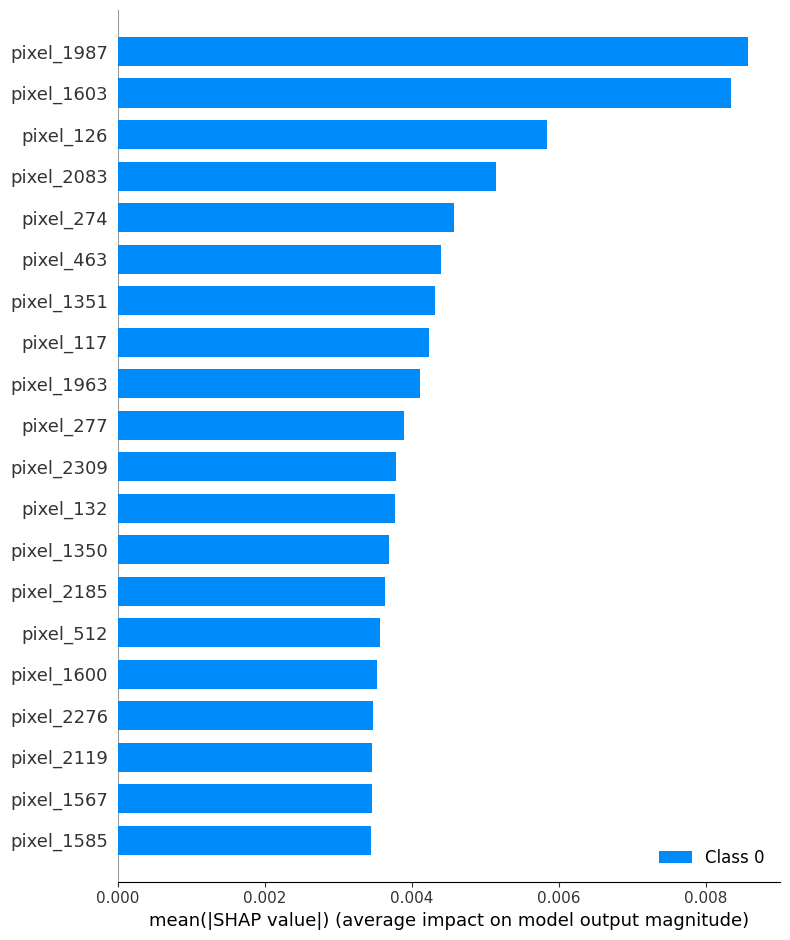

In [41]:
import shap

# KernelExplainer for CNN
explainer_cnn = shap.KernelExplainer(cnn_predict_wrapper, X_background_flat)
shap_values_cnn = explainer_cnn.shap_values(X_test_flat)

# Summary plot for CNN
shap.summary_plot(shap_values_cnn, X_test_flat, feature_names=[f"pixel_{i}" for i in range(X_test_flat.shape[1])])

In [42]:
cnn_probs = cnn_model.predict(X_cnn_resized).flatten()
key_features = df[['age', 'cholestoral', 'oldpeak']].values
X_fuzzy = np.hstack([key_features, cnn_probs.reshape(-1,1)])  # shape: (num_samples, 4)

# Train/test split for TSK if needed
X_fuzzy_test = X_fuzzy[:10]
X_fuzzy_background = X_fuzzy[:50]

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


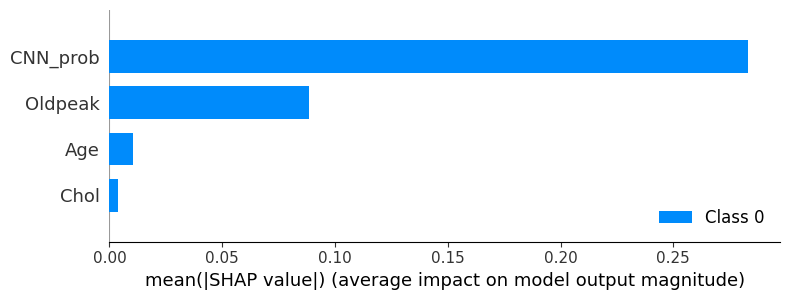

In [43]:
explainer_tsk = shap.KernelExplainer(tsk_model.predict, X_fuzzy_background)
shap_values_tsk = explainer_tsk.shap_values(X_fuzzy_test)

# Summary plot for TSK
feature_names = ['Age','Chol','Oldpeak','CNN_prob']
shap.summary_plot(shap_values_tsk, X_fuzzy_test, feature_names=feature_names)

In [44]:
risk_scores = tsk_model.predict(X_fuzzy_test).flatten()

# Map to severity
severity = np.where(risk_scores <= 0.33, 'Mild',
             np.where(risk_scores <= 0.66, 'Moderate', 'Severe'))

# Example display
for i in range(len(X_fuzzy_test)):
    print(f"Patient {i}: Risk Score={risk_scores[i]:.2f}, Severity={severity[i]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Patient 0: Risk Score=0.12, Severity=Mild
Patient 1: Risk Score=-0.08, Severity=Mild
Patient 2: Risk Score=0.00, Severity=Mild
Patient 3: Risk Score=0.00, Severity=Mild
Patient 4: Risk Score=0.10, Severity=Mild
Patient 5: Risk Score=0.86, Severity=Severe
Patient 6: Risk Score=-0.13, Severity=Mild
Patient 7: Risk Score=0.02, Severity=Mild
Patient 8: Risk Score=0.04, Severity=Mild
Patient 9: Risk Score=-0.08, Severity=Mild


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


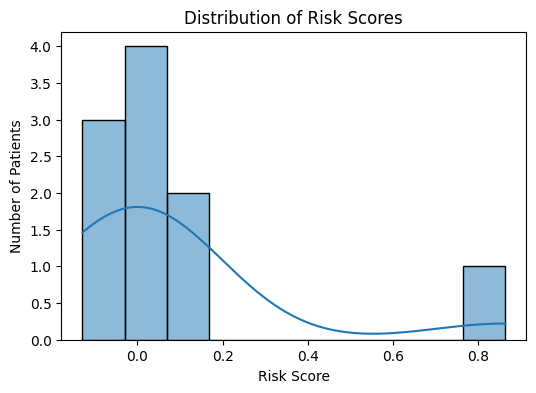

In [45]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(risk_scores, bins=10, kde=True)
plt.xlabel('Risk Score')
plt.ylabel('Number of Patients')
plt.title('Distribution of Risk Scores')
plt.show()


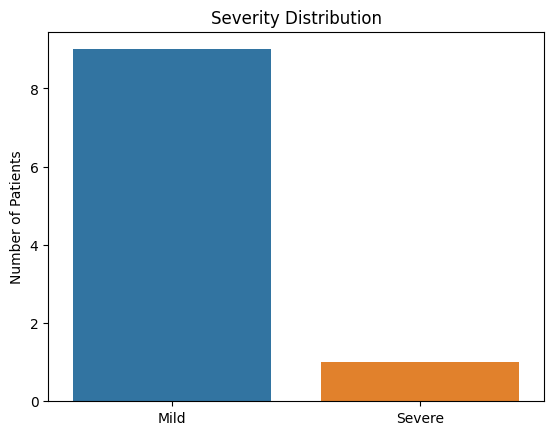

In [46]:
severity_counts = pd.Series(severity).value_counts()
sns.barplot(x=severity_counts.index, y=severity_counts.values)
plt.ylabel('Number of Patients')
plt.title('Severity Distribution')
plt.show()


In [47]:
# For CNN + TSK hybrid, use TSK final output
y_pred_prob = tsk_model.predict(X_fuzzy).flatten()  # continuous risk score (0-1)
y_true = y  

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


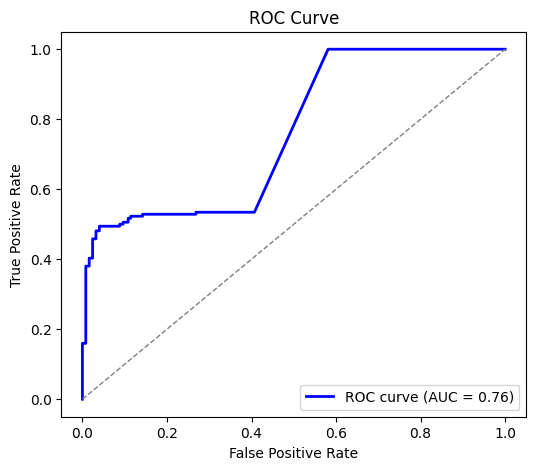

In [48]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

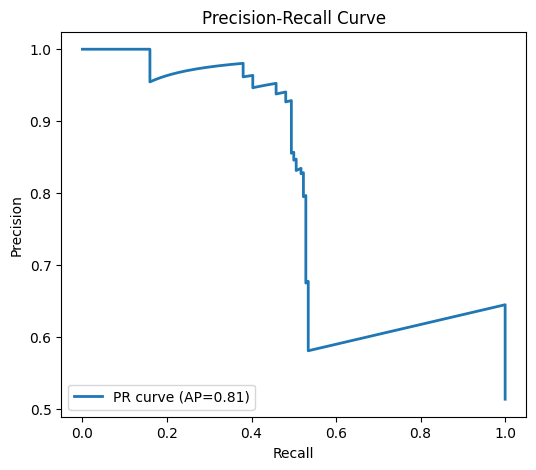

In [49]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
avg_precision = average_precision_score(y_true, y_pred_prob)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, lw=2, label=f'PR curve (AP={avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


Accuracy: 0.706
Precision: 0.938
Recall: 0.458
F1-score: 0.616


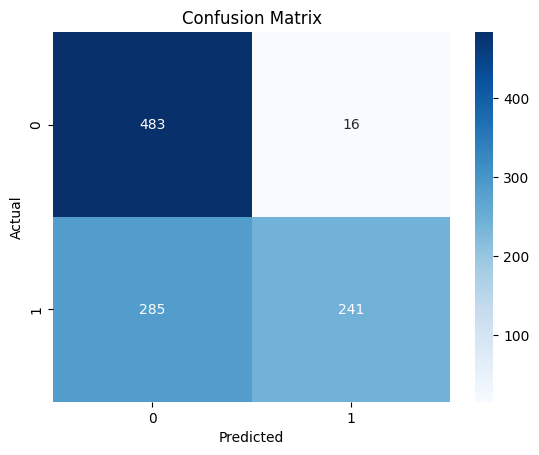

              precision    recall  f1-score   support

  No Disease       0.63      0.97      0.76       499
     Disease       0.94      0.46      0.62       526

    accuracy                           0.71      1025
   macro avg       0.78      0.71      0.69      1025
weighted avg       0.79      0.71      0.69      1025



In [50]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

# Convert risk scores to binary predictions using 0.5 threshold
y_pred = (y_pred_prob >= 0.5).astype(int)

# Accuracy, Precision, Recall, F1-score
accuracy = accuracy_score(y_true, y_pred)
precision_val = precision_score(y_true, y_pred)
recall_val = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision_val:.3f}")
print(f"Recall: {recall_val:.3f}")
print(f"F1-score: {f1:.3f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Detailed classification report
print(classification_report(y_true, y_pred, target_names=['No Disease','Disease']))
